In [2]:
import os
import sys
# sys.setdefaultencoding("utf-8")
import shutil
import random
import glob
import pandas as pd
import numpy as np
from scipy import stats
import subprocess
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from multiprocessing import Pool
from functools import reduce

In [12]:
# filter gene
GRCm38_genes = "/data/database/GRCm38/GENCODE/Genes_ensembl.bed"
GRCh38_genes = "/data/database/GRCh38/GENCODE/Genes_ensembl_dot.bed"
GRCh38_mRNA = "/home/galaxy/project/splicing/peak_density/CA/mRNA_region/mRNA_genes.bed"
# current data
peak_wt = "/home/galaxy/project/pausing_index/macs_result/wt_peaks.narrowPeak"
peak_ko = "/home/galaxy/project/pausing_index/macs_result/ko_peaks.narrowPeak"
# previous data
base_dir = "/data4/xs/2018_mettl3_KO_ser5/2017_xiaona_polII_ChIP/fq/bam/macs2"
pre_wt = "%s/wt_pol2_peaks.narrowPeak" % base_dir
pre_ko3 = "%s/ko3_pol2_peaks.narrowPeak" % base_dir
pre_ko4 = "%s/ko4_pol2_peaks.narrowPeak" % base_dir

In [3]:
# split bins
# First: -3kb; Second: peak; Third: +3kb
# gene = "chr1\t4490931\t4491354\tENSMUSG00000025902\t.\t-"
def split_each_segment(gene, seg): # seg = {a, b, c}
    bin_list, info_list = [], gene.split("\t")
    chro, start, end, name, strand = info_list[0], int(info_list[1]),  int(info_list[2]), info_list[3], info_list[5]
    gene_length = end - start
    bin_width = int(gene_length / 100)
#     print("Width of each bin: %d" % bin_width)
    total_positions = [i for i in range(start, end+1)]
    strand_dict  = {"+": 1, "-": 100}
    count = strand_dict[strand]
    for i in range(0, len(total_positions), bin_width):
        if ((strand == "+") and (count == 100)) | ((strand == "-") and (count == 1)):
            pos_list = total_positions[i:]
            bin_bed = "%s\t%d\t%d\t%s\t.\t%s" % (chro, pos_list[0], pos_list[-1], "%s_%s_%d" % (name, seg, count), strand)
            bin_list.append(bin_bed)
            break
        else:
            pos_list = total_positions[i:(i+bin_width+1)]
            bin_bed = "%s\t%d\t%d\t%s\t.\t%s" % (chro, pos_list[0], pos_list[-1], "%s_%s_%d" % (name, seg, count), strand)
            bin_list.append(bin_bed)
            if strand == "+": 
                count += 1
            else:
                count -= 1
    return bin_list

def split_region_bins(gene):
    info_list = gene.split("\t")
    chro, start, end, name, strand = info_list[0], int(info_list[1]),  int(info_list[2]), info_list[3], info_list[5]
    if strand == "-":
        up_start, up_end = end, end + 3000
        down_start, down_end = ((start-3000) if (start - 3000) > 0 else 0), start
    else:
        up_start, up_end = ((start-3000) if (start - 3000) > 0 else 0), start
        down_start, down_end = end, end + 3000
    up_bed = "%s\t%d\t%d\t%s\t.\t%s" % (chro, up_start, up_end, name, strand)
    down_bed = "%s\t%d\t%d\t%s\t.\t%s" % (chro, down_start, down_end, name, strand)
    a_bin_list = split_each_segment(up_bed, "a")
#     print(gene)
    b_bin_list = split_each_segment(gene, "b")
    c_bin_list = split_each_segment(down_bed, "c")
    bin_list = a_bin_list + b_bin_list + c_bin_list
    return bin_list

def split_gene_body(gene_bed):
    bin_list = []
    with open(GRCm38_genes, "r") as f:
        for line in f.readlines():
            if (int(line.split("\t")[2]) - int(line.split("\t")[1])) > 100:
                each_list = split_region_bins(line.strip())
                bin_list += each_list
    region_bed = "\n".join(bin_list)
    return region_bed

In [6]:
def count_overlapped_peak_numbers(region_bed, peak_bed):
    # Strand information isn't included in peak bed.
    command = "bedtools intersect -a stdin -b %s -c" % peak_bed
    sub_p = subprocess.Popen(command, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    output = sub_p.communicate(region_bed.encode("utf-8"))[0].decode("utf-8")
    return output

In [7]:
def parse_intersect_result(output, result_file):
    arrays = [x.split() for x in output.strip().split("\n")]
    df = pd.DataFrame(arrays).iloc[:, [3, -1]]
    df.columns = ["term", "count"]
    df["count"] = df["count"].astype(int)
    #
    df["seg_loc"] = df["term"].str.split("_").str[1]
    df["bin_loc"] = df["term"].str.split("_").str[-1]
    print(df.head())
    df_result = df.groupby(["seg_loc", "bin_loc"])["count"].sum()
    print(df_result.head())
    df_result.to_csv(result_file, sep="\t")
    return df, df_result
# def count_number(df):
#     print(df.iloc[0, [-2, -1]])
#     return df["count"].sum()
#     #
#     for t in ["a", "b", "c"]:
#         for i in range(1,101):
#             overlapped_num = df[df.iloc[:, -1].str.endswith("%s_%d" % (t, i))].iloc[:, -1].sum()
#             num_list.append(overlapped_num)
#     return num_list

In [13]:
region_bed = split_gene_body(GRCh38_mRNA) # GRCm38_genes
narrow_peak = "/home/galaxy/project/splicing/peak_density/CA/hglft_genome_6ad3_8dc3b0.bed"
output = count_overlapped_peak_numbers(region_bed, narrow_peak) # or peak_wt
df, df_result = parse_intersect_result(output, "/home/galaxy/project/splicing/peak_density/CA/binNums_mRNA.txt")

                     term  count seg_loc bin_loc
0  ENSMUSG00000102693_a_1      0       a       1
1  ENSMUSG00000102693_a_2      0       a       2
2  ENSMUSG00000102693_a_3      0       a       3
3  ENSMUSG00000102693_a_4      0       a       4
4  ENSMUSG00000102693_a_5      0       a       5
seg_loc  bin_loc
a        1          18
         10         12
         100        17
         11         11
         12          6
Name: count, dtype: int64


  seg_loc  bin_loc  wt_s2  wt_s5  ko_s2  ko_s5  x_values
0       a        1    119     79    160     15         1
1       a        2    119     80    160     15         2
2       a        3    123     85    164     15         3
3       a        4    127     87    163     17         4
4       a        5    127     89    161     17         5


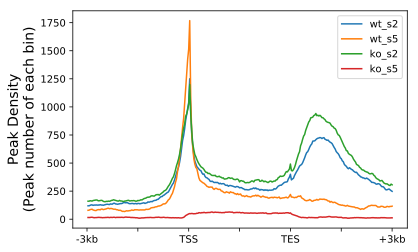

In [95]:
## plot
#######################################################################
# data_dir ="/home/galaxy/project/pausing_index/macs_result/"
# wt = "/home/galaxy/project/pausing_index/macs_result/binNums_wt.txt"
# ko ="/home/galaxy/project/pausing_index/macs_result/binNums_ko.txt"
#########################################################################
# data_dir = "/home/galaxy/project/pausing_index/previous_study"
# wt = "%s/binNums_wt.txt" % data_dir
# ko3 = "%s/binNums_ko3.txt" % data_dir
# ko4 = "%s/binNums_ko4.txt" % data_dir
#######################################################################################################
data_dir = "/data3/shijunfang/xialx2/xialx/pol2ser2ser5/clean_data/analysis2"
wt_s2 = "%s/binNums_wts2.txt" % data_dir
wt_s5 = "%s/binNums_wts5.txt" % data_dir
ko_s2 = "%s/binNums_kos2.txt" % data_dir
ko_s5 = "%s/binNums_kos5.txt" % data_dir
file_list = [wt_s2, wt_s5, ko_s2, ko_s5]
label_list = ["wt_s2", "wt_s5", "ko_s2", "ko_s5"]
rel_dict = dict(zip(file_list, label_list))
df_list = [pd.read_table(x, header=None, names=["seg_loc", "bin_loc", rel_dict[x]]) for x in file_list]
df_merge = reduce(lambda x,y: x.merge(y, on=["seg_loc", "bin_loc"]), df_list)
df = df_merge.sort_values(["seg_loc", "bin_loc"]).reset_index(drop=True)
df["x_values"] = df.index + 1
####################################################################################
print(df.head())
# sum_wt, sum_ko3, sum_ko4 = df["count_wt"].sum(), df["count_ko3"].sum(), df["count_ko4"].sum()
# df["Normalized_wt"] = df["count_wt"] / sum_wt
# df["Normalized_ko3"] = df["count_ko3"] / sum_ko3
# df["Normalized_ko4"] = df["count_ko4"] / sum_ko4
fig, ax = plt.subplots()
# plt.plot(df["x_values"], df["Normalized_wt"])
# plt.plot(df["x_values"], df["Normalized_ko3"])
# plt.plot(df["x_values"], df["Normalized_ko4"])
for label in label_list:
    plt.plot(df["x_values"], df[label])
plt.legend(label_list)
# plt.ylabel("Peak Density\n(Each bin/Total bin)", fontsize=14)
plt.ylabel("Peak Density\n(Peak number of each bin)", fontsize=14)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1], labels[3], labels[5], labels[7] = "-3kb", "TSS", "TES", "+3kb"
ax.set_xticklabels(labels)
fig.savefig("%s/peak_density_number.pdf" % data_dir)

In [34]:
with open("/home/galaxy/project/pausing_index/macs_result/region_bed_test.txt", 'w') as fw:
    fw.writelines(["%s\n" % x for x in region_bed.split("\n")])

In [36]:
with open("/home/galaxy/project/pausing_index/macs_result/output_test.txt", 'w') as fw:
    fw.writelines(["%s\n" % x for x in output.split("\n")])

In [ ]:
with open("/home/galaxy/project/pausing_index/macs_result/output_binNum.txt", 'w') as fw:
    fw.writelines(["%s\n" % str(x) for x in num_list])